머신러닝을 활용한 구리시세 예측
=================
-----------------------------------

![](https://image.fmkorea.com/files/attach/new2/20210920/192159903/2670156483/3928177586/19d3ba70a4b5426efe58bcf919b91478.jpeg)
## 1. 목적 : 구리 시세 영향을 주는 경제지표 영향도 분석으로 향후 시세가늠할 인사이트 제공
## 2. 방법 : 비철금속시세, 각종 경제지표 크롤링을 통한 데이터 수집, 전처리, EDA, 모델링, 평가 
## 3. 데이터 출처 
+ 구리 시세 : 비철금속협회
+ USD/JPY, WTI, M2(미국), 미국채(10년,1년) 금리 : 야후 파이낸스
+ SCFI : TRADLINX

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('C:\\Users\hdec\Downloads/비철금속data.csv',encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11366 entries, 0 to 11365
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11366 non-null  object 
 1   Cu          5257 non-null   float64
 2   Al          5257 non-null   float64
 3   Zn          5257 non-null   float64
 4   Pb          5257 non-null   float64
 5   Ni          5257 non-null   float64
 6   Sn          5257 non-null   float64
 7   USD/JPY     6268 non-null   float64
 8   WTI Crude   6269 non-null   float64
 9   M2          6268 non-null   float64
 10  SCFI        2883 non-null   float64
 11  10y_rate    11366 non-null  float64
 12  1y_rate     4038 non-null   float64
 13  Gap_10Y_1Y  4038 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1.2+ MB


### 데이터정제 
* 결측치 제거 : 데이터별 시계열 범위가 달라서 모든 데이터 시작점인 12년 9월 6일 이전자료는 제거

In [27]:
df['Unnamed: 0']=pd.to_datetime(df['Unnamed: 0'])
df=df.set_index(df['Unnamed: 0'])
df=df.drop('Unnamed: 0',axis=1)
df=df.dropna(axis=0)

## 시계열데이터 시각화

## 히스토그램
* 이상치 없으나 변수별 편차가 커서 MinMaxScaling 필요

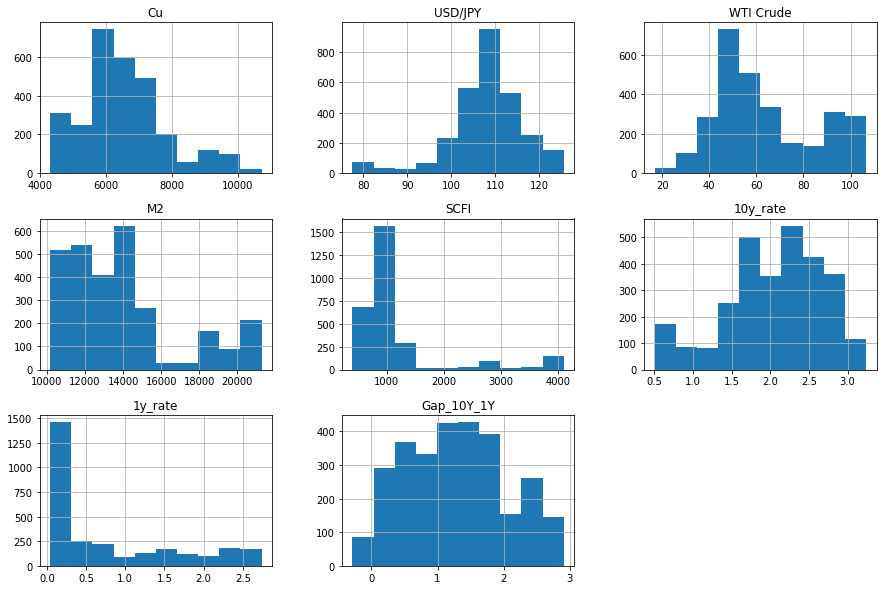

In [28]:
df_sk=df.copy()
df_sk.drop(['Al','Zn','Pb','Ni','Sn'],axis=1,inplace=True)
df_sk.hist(figsize=(15,10))
plt.show()

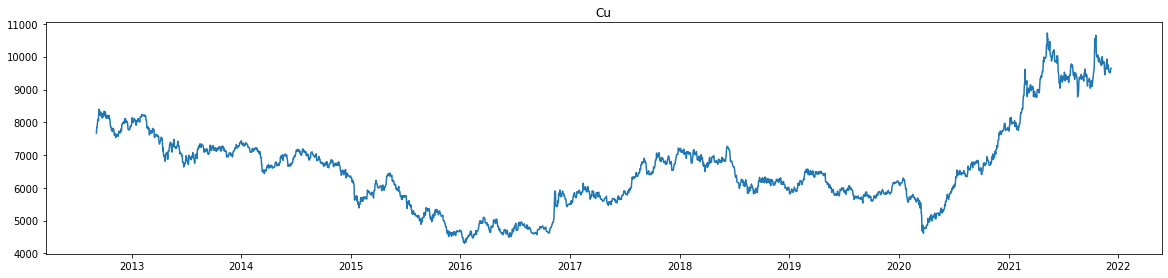

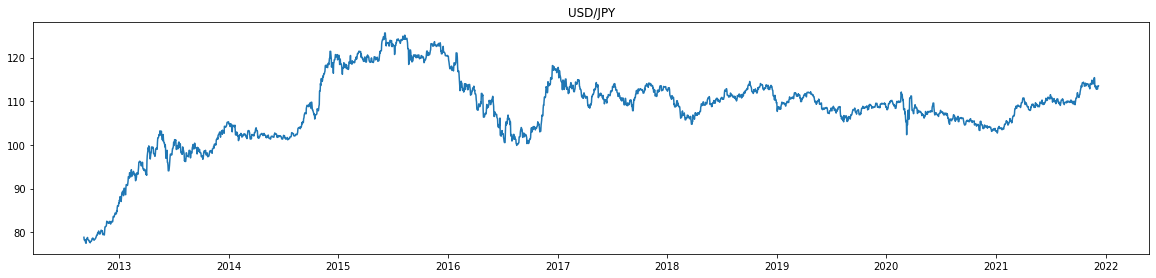

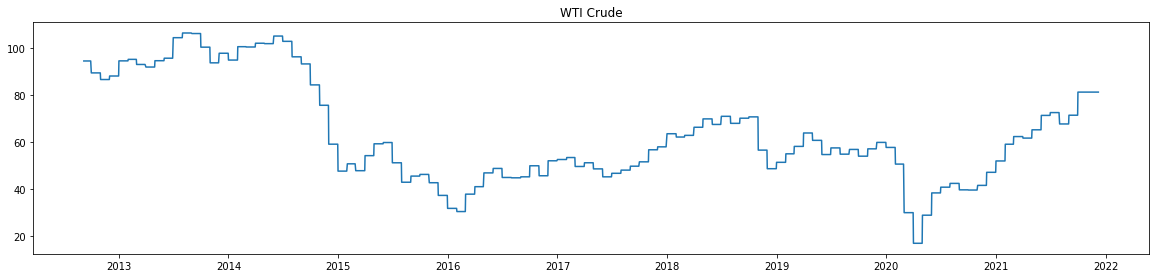

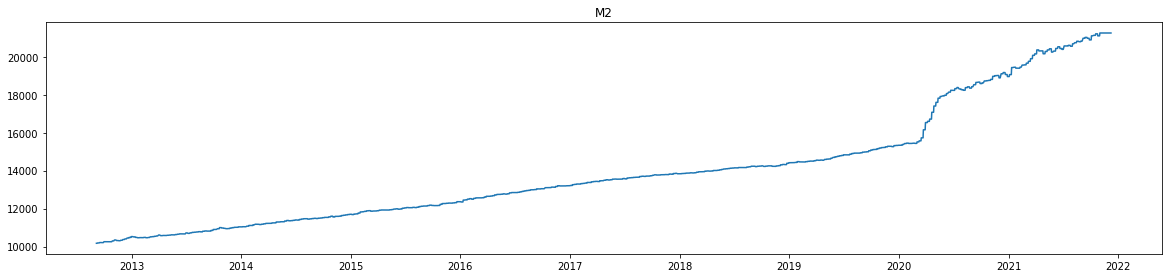

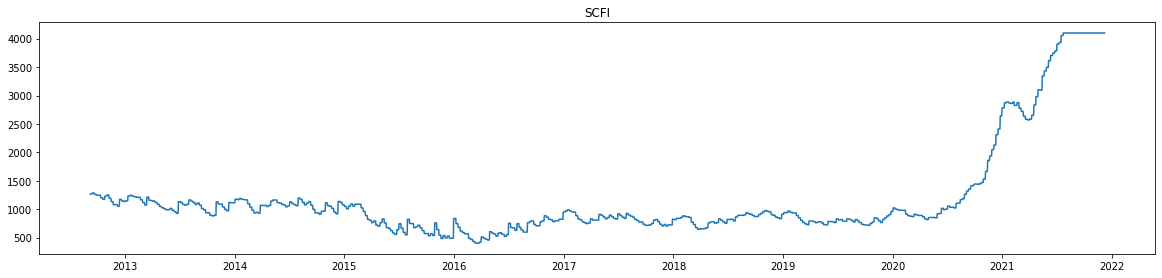

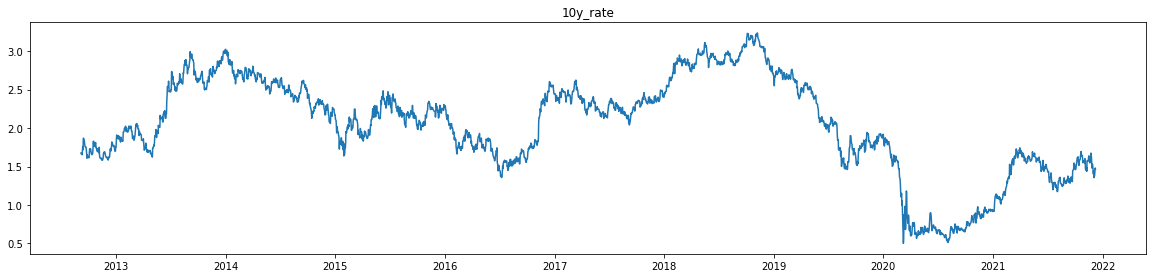

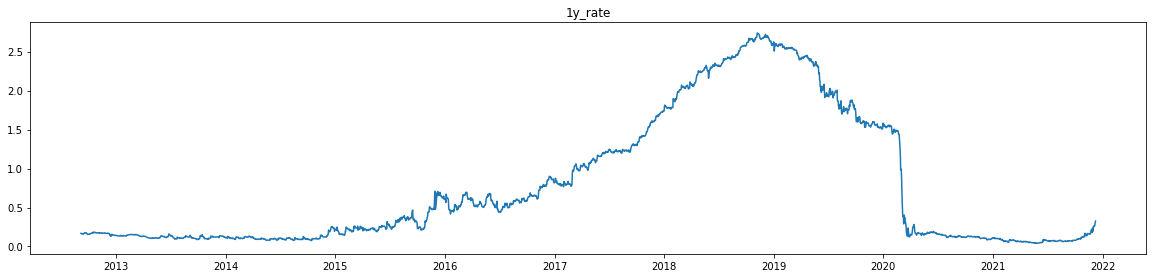

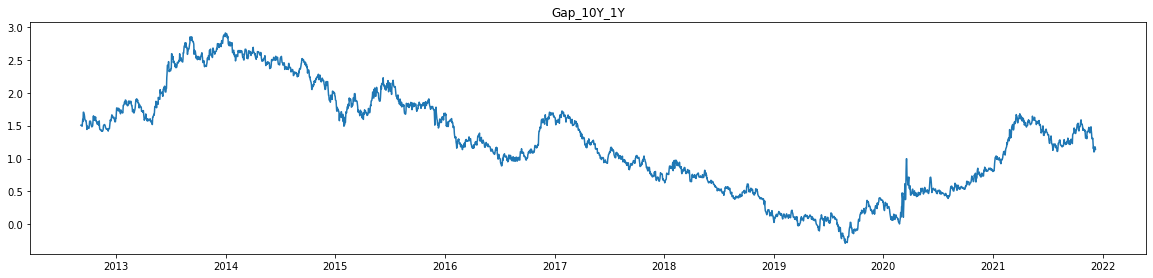

In [39]:
#df_sk.plot(secondary_y=['USD/JPY','10y_rate','1y_rate','Gap_10Y_1Y'],figsize=(15,8))

def making_line(x):
    plt.figure(figsize=(20,40))
    plt.subplot(8,1,i+1)
    plt.plot(df_sk.index,df_sk.iloc[:,i])
    plt.title(df_sk.columns[i])
    return plt.show()

for i in range(len(df_sk.columns)):
    making_line(i)

    

## 공분산 행렬
* 유가와 환율, 미국채금리와 통화량에서 음의 상관관계 확인되나 유의미한 정도는 아니므로 다중공선성은 없는 것으로 확인 
* 흥미로운 점은 SCFI(상하이선박지수)와 구리가격간에 강한 양의 상관관계가 있음
* 장단기금리는 파생변수이므로 패스


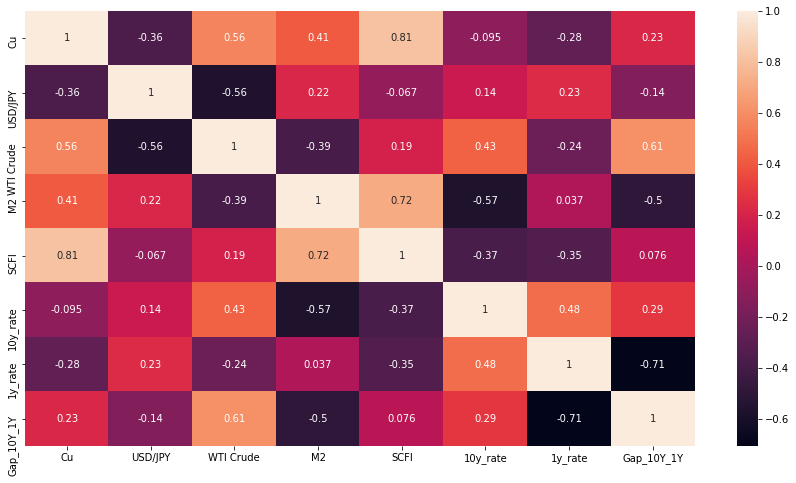

In [46]:
df_sk.corr()
f,ax=plt.subplots(figsize=(15,8))
ax=sns.heatmap(df_sk[['Cu','USD/JPY','WTI Crude','M2','SCFI','10y_rate','1y_rate','Gap_10Y_1Y']].corr(),annot=True)

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X=df_sk.drop('Cu',axis=1)
y=df_sk.Cu

# MinMaxScaling
sc=MinMaxScaler()
X_sc=sc.fit_transform(X)

#훈련용, 검증용 데이터 분리
import numpy as np
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y=train_test_split(X_sc,y,test_size=0.3,random_state=0)

#모델링
RF=RandomForestRegressor(n_estimators=300, max_depth=8, random_state=0)

RF.fit(train_X, train_y)
pred=RF.predict(test_X)


print("훈련용 R2=",RF.score(train_X,train_y)*100)
print("검증용 R2=",RF.score(test_X,test_y)*100)
print("RMSE=",np.sqrt(mean_squared_error(pred,test_y)))



훈련용 R2= 99.4515980606384
검증용 R2= 99.27707561500996
RMSE= 111.25757310710235


In [42]:
sc_no=sc.transform([[113.72,70.68,47178.2,4727.06,1.5495,0.5345,1.165]])
                   
print(RF.predict(sc_no))
np.sqrt(mean_squared_error(RF.predict(sc_no),[[9526]]))


#Cu  Al  USD/JPY  WTI Crude  M2  SCFI  10y_rate  1y_rate  Gap_10Y_1Y

[9658.51530613]


132.51530613245995

In [43]:
#모델링 예측치 산출
df_sk['est_Cu']=RF.predict(X_sc)

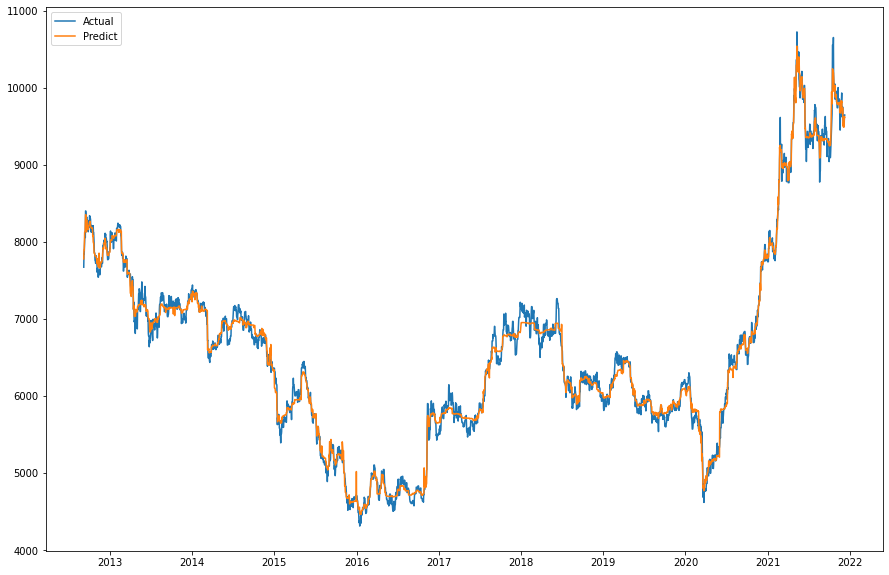

In [44]:
# 실제값, 예측치 시각화
f,ax=plt.subplots(figsize=(15,10))

ax.plot(df_sk.index,df_sk['Cu'],label='Actual')
ax.plot(df_sk.index,df_sk['est_Cu'],label='Predict')
plt.legend()
plt.show()

In [45]:
#변수별 중요도 산출
RF.feature_importances_
importances_dt= pd.DataFrame(RF.feature_importances_*100, columns=['Importance rate(%)'])
importances_dt.index=df_sk.columns[1:8]
importances_dt
# USD/JPY  WTI Crude  M2  SCFI  10y_rate  1y_rate  Gap_10Y_1Y

,Importance rate(%)
USD/JPY,1.831379
WTI Crude,20.285652
M2,20.262789
SCFI,55.112779
10y_rate,0.433083
1y_rate,1.413838
Gap_10Y_1Y,0.660478


마치며
===========
-------------------------------
## 1. LSTM 활용시 미래 시세 예측이 가능하나 기반영 변수 외 수많은 변수가 있으므로 생략
## 2. 유가, M2 통화량 변수 영향력 감안시 테이퍼링 시점에 따라 구리시세 변동성 감소 예상
## 3. 구리 관련 자재가격 시계열 데이터 활용시 동 모델링 기반 자재가 추정 가능